In [ ]:
!nvidia-smi

Sun Mar 30 18:01:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P5              7W /   75W |     500MiB /   6144MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import Dataset
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model, to_categorical
tf.debugging.set_log_device_placement(False)
tf.config.experimental_run_functions_eagerly(False)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
tf.debugging.set_log_device_placement(False)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from keras.layers import TFSMLayer
from keras import Input, Model
# from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from glob import glob
import re
from skimage import measure
import torchio as tio
import shutil
import cv2
import warnings
warnings.filterwarnings('ignore')

TensorFlow Version: 2.19.0
Num GPUs Available: 0
GPU Name: []
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
def dice_loss_per_class(y_true, y_pred, num_classes=3, smooth=1e-6):
    dice_scores = []

    for i in range(num_classes):
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])

        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)

    return 1 - K.mean(K.stack(dice_scores), axis=0)

def dice_score_per_class(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []

    for i in range(num_classes):
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])

        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)

    return K.mean(K.stack(dice_scores), axis=0)

def dice_metric(y_true, y_pred):
    return dice_score_per_class(y_true, y_pred, num_classes=4)

def dice_score_each_individual_class(y_true, y_pred, num_classes=3, smooth=1e-6):
    dice_scores = []

    for i in range(num_classes):
        y_true_class = tf.keras.backend.flatten(y_true[..., i])
        y_pred_class = tf.keras.backend.flatten(y_pred[..., i])

        intersection = tf.keras.backend.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (
            tf.keras.backend.sum(y_true_class) + tf.keras.backend.sum(y_pred_class) + smooth
        )
        dice_scores.append(dice)

    return dice_scores

In [ ]:
def resize_slice(slice, target_shape):
    return cv2.resize(slice, target_shape, interpolation=cv2.INTER_LINEAR)
def load_patient_slices(patient_folder, num_classes=4):
    images, masks = [], []

    for phase in ["ED", "ES"]:
        image_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_processed.nii.gz")
        mask_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_gt_processed.nii.gz")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"⚠️ Missing file: {image_path} or {mask_path}")
            continue

        image_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)

        image_array = image_nii.get_fdata()
        mask_array = mask_nii.get_fdata()

        image_array = (image_array - np.mean(image_array)) / (np.std(image_array) + 1e-10)

        for i in range(image_array.shape[2]):
            img_slice = image_array[:, :, i]
            mask_slice = mask_array[:, :, i]
            if img_slice.shape != (224, 224):
                img_slice = resize_slice(img_slice, (224, 224))
            if mask_slice.shape != (224, 224):
                mask_slice = resize_slice(mask_slice, (224, 224))
            img_slice = np.expand_dims(img_slice, axis=-1)

            mask_slice = to_categorical(mask_slice, num_classes=num_classes).astype("float32")

            images.append(img_slice)
            masks.append(mask_slice)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

def load_dataset(root_dir, dataset_type):
    images, masks = [], []
    dataset_path = os.path.join(root_dir, dataset_type)

    for patient_folder in sorted(os.listdir(dataset_path)):
        patient_path = os.path.join(dataset_path, patient_folder)

        if os.path.isdir(patient_path):
            patient_id = patient_folder[-3:]
            patient_images, patient_masks = load_patient_slices(patient_path, num_classes = 4)
            print(f"✅ Loaded {len(patient_images)} images and {len(patient_masks)} masks from {patient_folder}")
            images.extend(patient_images)
            masks.extend(patient_masks)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

In [ ]:
# X_train, Y_train = load_dataset("D:\Advanced_Python\projects\MLMED\cropped_slices_processed", "training")
# X_val, Y_val = load_dataset("D:\Advanced_Python\projects\MLMED\cropped_slices_processed", 'validation')
X_test, Y_test = load_dataset("D:\Advanced_Python\projects\MLMED\cropped_slices_processed", "testing")

# print(f"✅ Training Data: {X_train.shape}, {Y_train.shape}")
# print(f"✅ Validation Data: {X_val.shape}, {Y_val.shape}")
print(f"✅ Testing Data: {X_test.shape}, {Y_test.shape}")

✅ Loaded 17 images and 17 masks from patient101
✅ Loaded 13 images and 13 masks from patient102
✅ Loaded 15 images and 15 masks from patient103
✅ Loaded 12 images and 12 masks from patient104
✅ Loaded 13 images and 13 masks from patient105
✅ Loaded 18 images and 18 masks from patient106
✅ Loaded 15 images and 15 masks from patient107
✅ Loaded 14 images and 14 masks from patient108
✅ Loaded 15 images and 15 masks from patient109
✅ Loaded 15 images and 15 masks from patient110
✅ Loaded 10 images and 10 masks from patient111
✅ Loaded 14 images and 14 masks from patient112
✅ Loaded 18 images and 18 masks from patient113
✅ Loaded 14 images and 14 masks from patient114
✅ Loaded 15 images and 15 masks from patient115
✅ Loaded 16 images and 16 masks from patient116
✅ Loaded 17 images and 17 masks from patient117
✅ Loaded 15 images and 15 masks from patient118
✅ Loaded 15 images and 15 masks from patient119
✅ Loaded 12 images and 12 masks from patient120
✅ Loaded 15 images and 15 masks from pat

In [ ]:
def random_gamma(image):
    image = tf.clip_by_value(image, 1e-3, 1.0)
    gamma = tf.random.uniform([], 0.95, 1.05)
    image = tf.pow(image, gamma)
    return image

def augment(image, mask):
    image = tf.debugging.check_numerics(image, "Before augment")
    if tf.random.uniform(()) > 0.8:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.8:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = random_gamma(image)
    return image, mask
def create_tf_dataset(images, masks, batch_size, augment_data):
        images = images.astype("float32")
        masks = masks.astype("float32")

        dataset = tf.data.Dataset.from_tensor_slices((images, masks))
        if augment_data:
            dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    test_dataset = create_tf_dataset(X_test, Y_test, batch_size=8, augment_data=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
layer = TFSMLayer(r"D:\Advanced_Python\projects\MLMED\models\best_unet_2d", call_endpoint="serving_default")

inputs = Input(shape=(224, 224, 1))
outputs = layer(inputs)
model = Model(inputs, outputs)

In [ ]:
os.environ["TF_DISABLE_MKL"] = "1"

y_preds, y_trues = [], []
for x, y in test_dataset:
    pred = model.predict(x)

    if isinstance(pred, dict):
        pred = list(pred.values())[0]

    y_preds.append(pred)
    y_trues.append(y)

y_preds = tf.concat(y_preds, axis=0)
y_trues = tf.concat(y_trues, axis=0)

dice = dice_score_per_class(y_trues, y_preds, num_classes=4)
print("✅ Dice Score average:", dice.numpy())

scores = dice_score_each_individual_class(y_trues, y_preds, num_classes=4)

score_arr = []
for i, score in enumerate(scores):
    print(f"Dice score for class {i}: {(score.numpy()*100):.4f}")
    score_arr.append(score)

total_score = 0
for score in score_arr[1:]:
    total_score+=score
print(f"Average of 3 main classes: {total_score/3*100:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

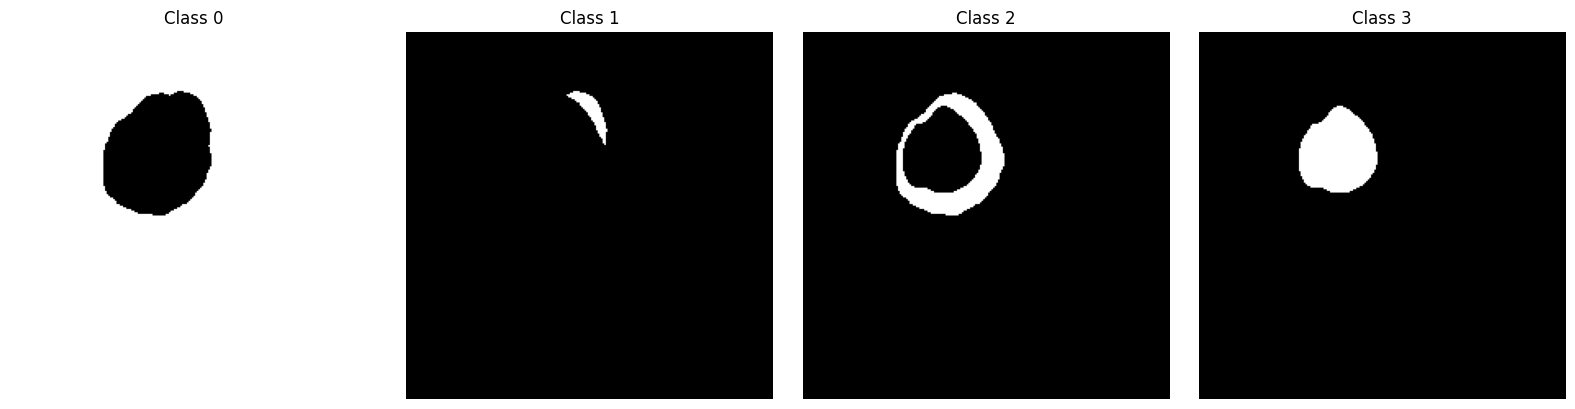

In [ ]:
preds_np = y_preds.numpy()

pred = preds_np[13]
threshold = 0.5
binary_pred = (pred > threshold).astype(np.uint8)

class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(binary_pred[:, :, i], cmap='gray')
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

---
## last stretch

In [ ]:
# Load the dataset with metadata
X_test, Y_test, test_metadata = load_dataset("D:\\Advanced_Python\\projects\\MLMED\\cropped_slices_processed", "testing")
print(f"✅ Testing Data: {X_test.shape}, {Y_test.shape}, Metadata: {len(test_metadata)}")

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    test_dataset = create_tf_dataset(X_test, Y_test, batch_size=8, augment_data=False, shuffle=False)
    layer = TFSMLayer(r"D:\Advanced_Python\projects\MLMED\models\best_unet_2d", call_endpoint="serving_default")
    inputs = Input(shape=(224, 224, 1))
    outputs = layer(inputs)
    model = Model(inputs, outputs)

os.environ["TF_DISABLE_MKL"] = "1"

In [ ]:
y_preds, y_trues = [], []
for x, y in test_dataset:
    pred = model.predict(x)
    if isinstance(pred, dict):
        pred = list(pred.values())[0]
    y_preds.append(pred)
    y_trues.append(y)

y_preds = tf.concat(y_preds, axis=0)
y_trues = tf.concat(y_trues, axis=0)

In [ ]:
dice = dice_score_per_class(y_trues, y_preds, num_classes=4)
print("✅ Dice Score average:", dice.numpy())

scores = dice_score_each_individual_class(y_trues, y_preds, num_classes=4)

score_arr = []
for i, score in enumerate(scores):
    print(f"Dice score for class {i}: {(score.numpy()*100):.4f}")
    score_arr.append(score)

total_score = 0
for score in score_arr[1:]:
    total_score+=score
print(f"Average of 3 main classes: {total_score/3*100:.4f}")

✅ Dice Score average: 0.9132192
Dice score for class 0: 99.3691
Dice score for class 1: 86.1792
Dice score for class 2: 85.9414
Dice score for class 3: 93.7979
Average of 3 main classes: 88.6395


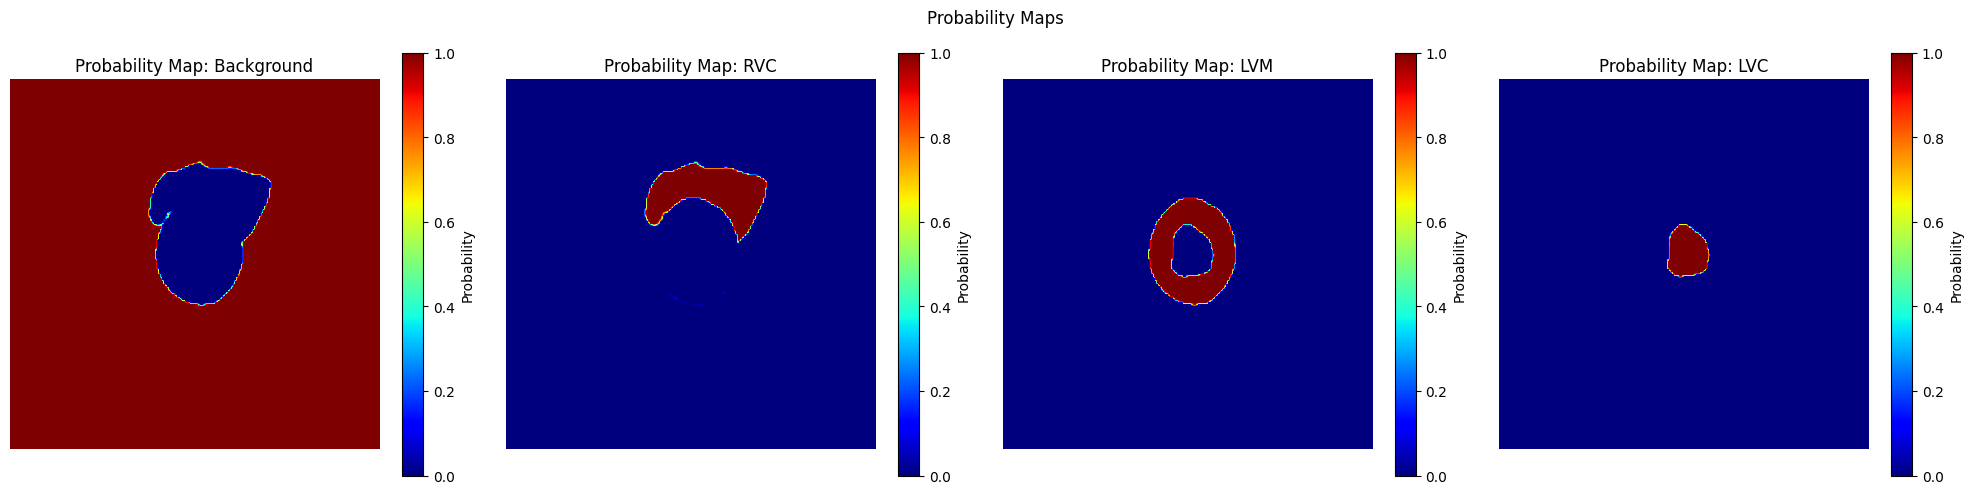

In [ ]:
pred_slice = y_preds[0].numpy()

class_names = ['Background' ,'RVC', 'LVM', 'LVC']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for class_idx in range(4):
    ax = axes[class_idx]
    prob_map = pred_slice[:, :, class_idx]
    im = ax.imshow(prob_map, cmap='jet', vmin=0, vmax=1)
    ax.set_title(f"Probability Map: {class_names[class_idx]}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, label='Probability')

plt.suptitle(f"Probability Maps")
plt.tight_layout()
plt.show()

---

In [ ]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import TFSMLayer

In [ ]:
def resize_slice(slice, target_shape):
    return cv2.resize(slice, target_shape, interpolation=cv2.INTER_LINEAR)

def load_patient_slices(patient_folder, num_classes=4):
    images, masks, slice_metadata = [], [], []

    for phase in ["ED", "ES"]:
        image_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_processed.nii.gz")
        mask_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_gt_processed.nii.gz")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"⚠️ Missing file: {image_path} or {mask_path}")
            continue

        image_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)

        image_array = image_nii.get_fdata()
        mask_array = mask_nii.get_fdata()

        image_array = (image_array - np.mean(image_array)) / (np.std(image_array) + 1e-10)

        for i in range(image_array.shape[2]):
            img_slice = image_array[:, :, i]
            mask_slice = mask_array[:, :, i]
            if img_slice.shape != (224, 224):
                img_slice = resize_slice(img_slice, (224, 224))
            if mask_slice.shape != (224, 224):
                mask_slice = resize_slice(mask_slice, (224, 224))
            img_slice = np.expand_dims(img_slice, axis=-1)
            mask_slice = to_categorical(mask_slice, num_classes=num_classes).astype("float32")

            images.append(img_slice)
            masks.append(mask_slice)
            slice_metadata.append({"phase": phase, "slice_idx": i})

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32), slice_metadata

def load_dataset(root_dir, dataset_type):
    images, masks, all_metadata = [], [], []
    dataset_path = os.path.join(root_dir, dataset_type)

    for patient_folder in sorted(os.listdir(dataset_path)):
        patient_path = os.path.join(dataset_path, patient_folder)

        if os.path.isdir(patient_path):
            patient_id = patient_folder[-3:]
            patient_images, patient_masks, patient_metadata = load_patient_slices(patient_path, num_classes=4)
            print(f"✅ Loaded {len(patient_images)} images and {len(patient_masks)} masks from {patient_folder}")
            images.extend(patient_images)
            masks.extend(patient_masks)
            for meta in patient_metadata:
                meta["patient_id"] = patient_id
            all_metadata.extend(patient_metadata)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32), all_metadata

def create_tf_dataset(images, masks, batch_size, augment_data, shuffle=True):
    images = images.astype("float32")
    masks = masks.astype("float32")

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Load the dataset with metadata
X_test, Y_test, test_metadata = load_dataset("D:\\Advanced_Python\\projects\\MLMED\\cropped_slices_processed", "testing")
print(f"✅ Testing Data: {X_test.shape}, {Y_test.shape}, Metadata: {len(test_metadata)}")

In [ ]:
## 3 CLASSES
from tensorflow.keras.layers import Input, Lambda
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    layer = TFSMLayer(r"D:\Advanced_Python\projects\MLMED\models\best_unet_2d", call_endpoint="serving_default")
    inputs = Input(shape=(224, 224, 1))
    outputs = layer(inputs)
    if isinstance(outputs, dict):
        outputs = list(outputs.values())[0]
    outputs_sliced = Lambda(lambda x: x[:, :, :, 1:])(outputs)
    model = Model(inputs=inputs, outputs=outputs_sliced)

In [ ]:
y_preds, y_trues = [], []
for x, y in test_dataset:
    pred = model.predict(x)
    y_preds.append(pred)
    y_trues.append(y)

y_preds = tf.concat(y_preds, axis=0)
y_trues = tf.concat(y_trues, axis=0)

print("Prediction shape:", y_preds.shape)

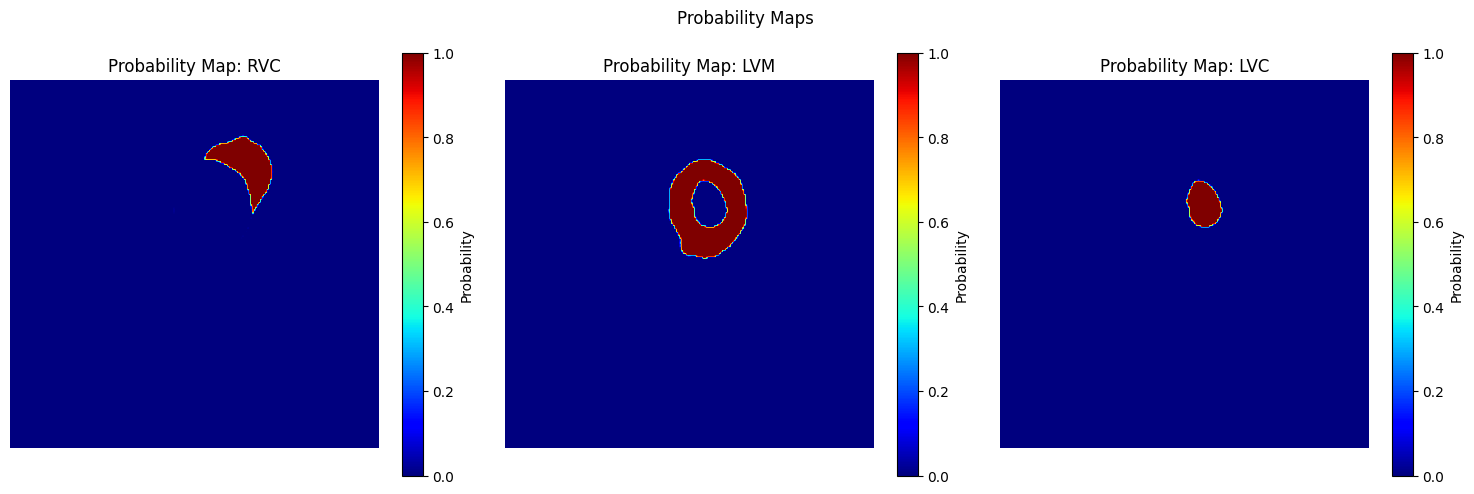

In [ ]:
pred_slice = y_preds[0].numpy()

class_names = ['RVC', 'LVM', 'LVC']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for class_idx in range(3):
    ax = axes[class_idx]
    prob_map = pred_slice[:, :, class_idx]
    im = ax.imshow(prob_map, cmap='jet', vmin=0, vmax=1)
    ax.set_title(f"Probability Map: {class_names[class_idx]}")
    ax.axis('off')
    plt.colorbar(im, ax=ax, label='Probability')

plt.suptitle(f"Probability Maps")
plt.tight_layout()
plt.show()

In [ ]:
predictions_dir = "predictions"
os.makedirs(predictions_dir, exist_ok=True)

for i, meta in enumerate(test_metadata):
    patient_id = meta["patient_id"]
    phase = meta["phase"]
    slice_idx = meta["slice_idx"]
    save_dir = os.path.join(predictions_dir, f"patient{patient_id}", phase)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"slice{slice_idx}.npy")
    pred_slice = y_preds[i].numpy()
    print(f"Slice shape for patient{patient_id}, {phase}, slice{slice_idx}: ", pred_slice.shape)
    np.save(save_path, pred_slice)

Slice shape for patient101, ED, slice0:  (224, 224, 3)
Slice shape for patient101, ED, slice1:  (224, 224, 3)
Slice shape for patient101, ED, slice2:  (224, 224, 3)
Slice shape for patient101, ED, slice3:  (224, 224, 3)
Slice shape for patient101, ED, slice4:  (224, 224, 3)
Slice shape for patient101, ED, slice5:  (224, 224, 3)
Slice shape for patient101, ED, slice6:  (224, 224, 3)
Slice shape for patient101, ED, slice7:  (224, 224, 3)
Slice shape for patient101, ED, slice8:  (224, 224, 3)
Slice shape for patient101, ES, slice0:  (224, 224, 3)
Slice shape for patient101, ES, slice1:  (224, 224, 3)
Slice shape for patient101, ES, slice2:  (224, 224, 3)
Slice shape for patient101, ES, slice3:  (224, 224, 3)
Slice shape for patient101, ES, slice4:  (224, 224, 3)
Slice shape for patient101, ES, slice5:  (224, 224, 3)
Slice shape for patient101, ES, slice6:  (224, 224, 3)
Slice shape for patient101, ES, slice7:  (224, 224, 3)
Slice shape for patient102, ED, slice0:  (224, 224, 3)
Slice shap

Loaded: D:\Advanced_Python\projects\MLMED\outputs\output_2d\patient101\ED\slice0.npy, shape: (224, 224, 3)


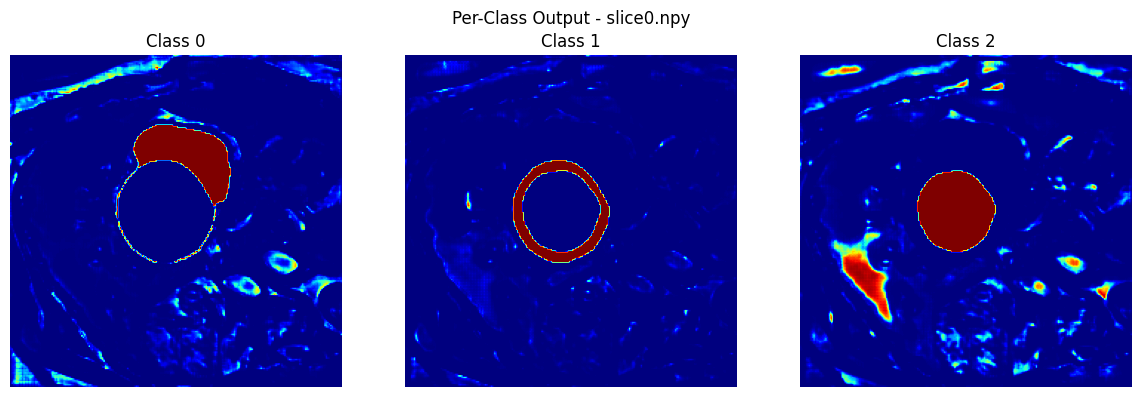

In [ ]:
npy_path = r"D:\Advanced_Python\projects\MLMED\outputs\output_2d\patient101\ED\slice0.npy"
arr = np.load(npy_path)  # (H, W, C)
print(f"Loaded: {npy_path}, shape: {arr.shape}")

h, w, c = arr.shape
fig, axs = plt.subplots(1, c, figsize=(4*c, 4))

for i in range(c):
    axs[i].imshow(arr[:, :, i], cmap='jet')
    axs[i].set_title(f"Class {i}")
    axs[i].axis("off")

plt.suptitle(f"Per-Class Output - {os.path.basename(npy_path)}")
plt.tight_layout()
plt.show()